In [8]:
%config InlineBackend.figure_formats = ['svg']
import sys
sys.path.insert(1, '../')

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from os import path

from deployment_instance import ExperimentResult
from src.ingest_data import ingest_experiment_results
from src.query_data import get_data_exfiltration_times, percent_of_data_exfiltrated
from statistics import mean
import seaborn as sns

from lifelines import KaplanMeierFitter
import pandas as pd

In [9]:
# Baseline attacker
baseline_layered_d2_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxSmall/baseline_layered_d2_h50'))
baseline_reactive_d2_h50 = ingest_experiment_results(path.join('data/Reactive/EquifaxSmall/baseline_reactiveLayered_d2_h50'))

# DFS attacker
dfs_layered_d2_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxSmall/dfs_layered_d2_h50'))
dfs_reactive_d2_h50 = ingest_experiment_results(path.join('data/Reactive/EquifaxSmall/dfs_reactiveLayered_d2_h50'))

bfs_layered_d2_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxSmall/bfs_layered_d2_h50'))
bfs_reactive_d2_h50 = ingest_experiment_results(path.join('data/Reactive/EquifaxSmall/bfs_reactiveLayered_d2_h50'))

In [10]:
baseline_layered_d2_h50_times = get_data_exfiltration_times(baseline_layered_d2_h50, expected_files=12)
baseline_reactive_d2_h50_times = get_data_exfiltration_times(baseline_reactive_d2_h50, expected_files=12)

dfs_layered_d2_h50_times = get_data_exfiltration_times(dfs_layered_d2_h50, expected_files=12)
dfs_reactive_d2_h50_times = get_data_exfiltration_times(dfs_reactive_d2_h50, expected_files=12)

bfs_layered_d2_h50_times = get_data_exfiltration_times(bfs_layered_d2_h50, expected_files=12)
bfs_reactive_d2_h50_times = get_data_exfiltration_times(bfs_reactive_d2_h50, expected_files=12)

In [11]:
colors = ['tab:grey', 'tab:pink', 'tab:blue']

def plot_survival(df_list, ax):
    color_idx = 0

    for df in df_list:
        # Fit the Kaplan-Meier estimator
        kmf = KaplanMeierFitter()
        kmf.fit(df['time_exfiltrated'], df['survival'])

        # Using Seaborn for a more customized plot
        ax.step(kmf.survival_function_.index, kmf.survival_function_["KM_estimate"], where="post", color=colors[color_idx])
        color_idx += 1

    # set range of x-axis to 0-60
    ax.set_xlim(0, 60)
    # ax.title('Survival Function')
    # ax.xlabel('Time')
    # ax.ylabel('Survival Probability')

    kmf.survival_function_["KM_estimate"]

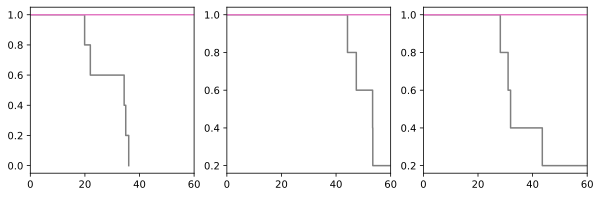

In [12]:
fig, axs = plt.subplots(figsize=(10, 3), ncols=3)
plot_survival([baseline_layered_d2_h50_times, baseline_reactive_d2_h50_times], axs[0])
plot_survival([dfs_layered_d2_h50_times, dfs_reactive_d2_h50_times], axs[1])
plot_survival([bfs_layered_d2_h50_times, bfs_reactive_d2_h50_times], axs[2])
#fig.savefig('./plots/layered_survival_equiSmall.svg', transparent=True)

In [13]:
baseline_reactive_d2_h50_times

,time_exfiltrated,survival,num_files
0,60,0,0
1,60,0,0
2,60,0,0
3,60,0,0
4,60,0,0
5,60,0,0
6,60,0,0
7,60,0,0
8,60,0,0
